In [3]:
import sys
import pickle
sys.path.append("C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/tools/")
sys.path.append("C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/final_project/")
import matplotlib.pyplot as plt
from time import time

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time


In [4]:
with open("C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/final_project\
/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)

# Stats on Dataset

In [5]:
# stats
print 'Number of people:', df['poi'].count()
print 'Number of POIs:', df.loc[df.poi == True, 'poi'].count()
print 'Ratio of examples that are POIs:', \
    float(df.loc[df.poi == True, 'poi'].count()) / df['poi'].count()
print 'Number of features:', df.shape[1]

Number of people: 146
Number of POIs: 18
Ratio of examples that are POIs: 0.123287671233
Number of features: 21


In [6]:
#The counts of missing values in each feature
print 'Missing values in each column'
df.isnull().sum()

Missing values in each column


salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                 35
from_poi_to_this_person       60
dtype: int64

Looking at the missing values, I can see all the emails related data has same number of data points. This can be due to multiple reasons. Either the data is intentionally not provided or due to some privacy perspective.

In [7]:
df['email_withheld'] = df.to_messages.isnull()
df.groupby(['email_withheld', 'poi'])['poi'].count()

email_withheld  poi  
False           False    72
                True     14
True            False    56
                True      4
Name: poi, dtype: int64

From the above analysis, it doesn't look like the emails withheld were majorly from POI. But I will use this new feature in the modelling and see if that helps.

In [8]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', \
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', \
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', \
                  'shared_receipt_with_poi']


In [9]:
df[financial_features] = df[financial_features].fillna(0)

For Financial features I have filled '0' for all the missing values but in case of emails if I fill '0' close to half of my training data is going be missed and thats a lot of information loss and ML models might not be that useful so I have chosen to fill all the missing values with the median of that features.

In [10]:
df[email_features] = df[email_features].fillna(df[email_features].median())

# Outliers

Now as the missing vales are fixed, let us look into the outliers and how to remove them. I am going to use Seaborn library to plot pairs of plots

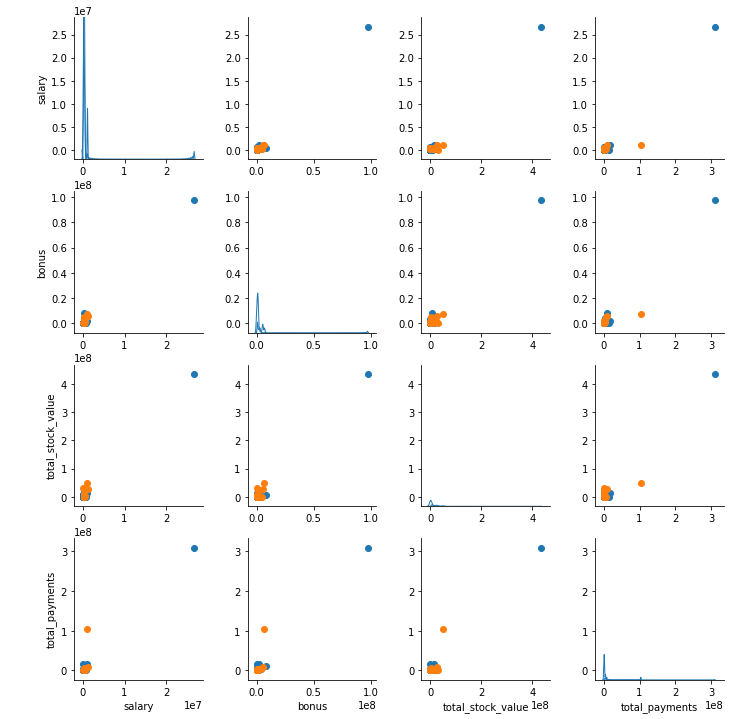

In [11]:
import seaborn as sns
g = sns.PairGrid(df, vars=['salary','bonus','total_stock_value','total_payments'],
                hue='poi')
g.map_lower(plt.scatter)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=1)
plt.show()

One point stands out in all the plots. It is not a POI so let me investigate further on this point

In [12]:
df[df.salary > 2.5e7]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,email_withheld
TOTAL,26704229.0,1211.0,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,740.5,-7576788.0,434509511.0,...,41.0,42667589.0,8.0,False,1398517.0,-27992891.0,48521928.0,NaN,35.0,True


This point looks like is the total values of each column. It is not a relevant data point so I am going to drop this record.

In [13]:
df = df.drop('TOTAL')

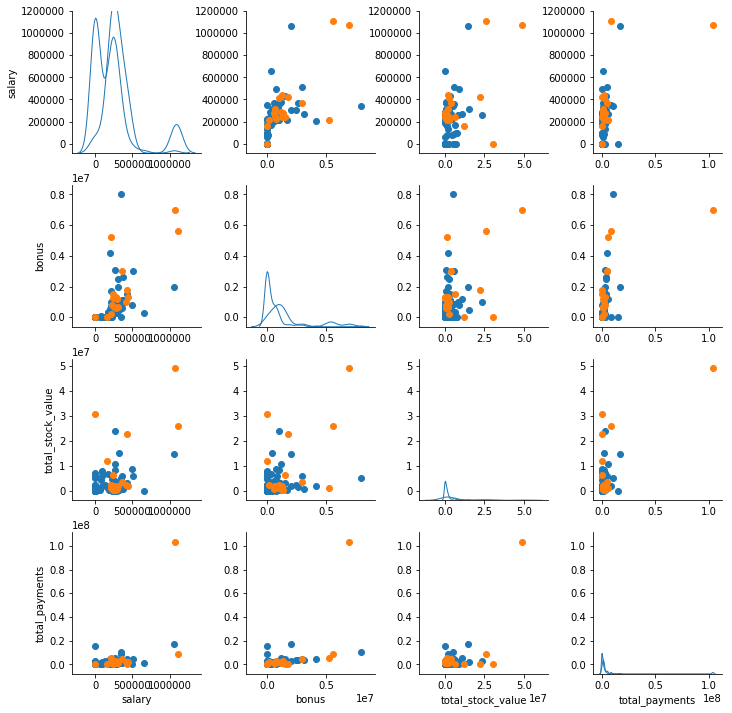

In [41]:
g = sns.PairGrid(df, vars=['salary','bonus','total_stock_value','total_payments'],
                hue='poi')
g.map_lower(plt.scatter)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=1)
plt.show()

Rest of the plots after removing the "total" looks good. So after the financial features I am looking into the email features.

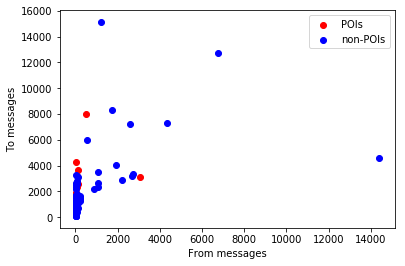

In [14]:
pois = df[df.poi]
plt.scatter(pois.from_messages, pois.to_messages, c='red');
non_pois = df[~df.poi]
plt.scatter(non_pois.from_messages, non_pois.to_messages, c='blue');

plt.xlabel('From messages')
plt.ylabel('To messages')
plt.legend(['POIs', 'non-POIs'])
plt.show()

There are 3 points that seem to be sending far too many emails and recieving too than rest of the folks. So let me look into these specific emails 

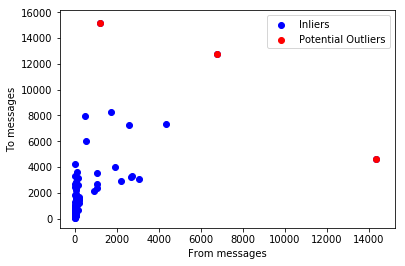

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,email_withheld
KAMINSKI WINCENTY J,275101.0,4607.0,0.0,1086821.0,850010.0,400000.0,126027.0,583.0,0.0,976037.0,...,14368.0,4669.0,171.0,False,0.0,0.0,323466.0,vince.kaminski@enron.com,41.0,False
KEAN STEVEN J,404338.0,12754.0,0.0,1747522.0,2022048.0,1000000.0,4131594.0,3639.0,0.0,6153642.0,...,6759.0,1231.0,387.0,False,0.0,0.0,300000.0,steven.kean@enron.com,140.0,False
SHAPIRO RICHARD S,269076.0,15149.0,0.0,1057548.0,607837.0,650000.0,379164.0,4527.0,0.0,987001.0,...,1215.0,705.0,65.0,False,0.0,0.0,0.0,richard.shapiro@enron.com,74.0,False


In [15]:
# outlier points
outliers = df[np.logical_or(df.from_messages > 6000, df.to_messages > 10000)]

#plot them in red with the originals
plt.scatter(df.from_messages, df.to_messages, c='blue');
plt.scatter(outliers.from_messages, outliers.to_messages, c='red')
plt.xlabel('From messages')
plt.ylabel('To messages')
plt.legend(['Inliers', 'Potential Outliers'])
plt.show()

outliers

From other features it doesnt look anything strange with these 3 records and persons in particular. So dropping these records

In [16]:
# remove the outliers
df = df[df.from_messages < 6000]
df = df[df.to_messages < 10000]

# Machine Learning

In [17]:
X = df.drop(['poi', 'email_address'], axis=1)
y = df.poi

In [42]:
# firstly get an estimate of the kind of accuracies we can expect with the unprocessed features
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import classification_report

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def classifier_metrics(clf, X, y):


    cv = StratifiedShuffleSplit(y, 100, random_state=42)

    print 'accuracy', cross_val_score(clf, X, y, cv=cv).mean()
    print 'precision', cross_val_score(clf, X, y, scoring=make_scorer(precision_score), cv=cv).mean()
    print 'recall', cross_val_score(clf, X, y, scoring=make_scorer(recall_score), cv=cv).mean()
    
    
def classifiers_results(X, y):
    print 'RandomForestClassifier'
    clf = RandomForestClassifier(random_state=42)
    classifier_metrics(clf, X, y)
    print '------------------------'
    print 'GaussianNB Classifier'
    
    clf = GaussianNB()
    classifier_metrics(clf, X, y)    
    print '------------------------'
    print 'AdaBoost Classifier'
    
    clf = AdaBoostClassifier(random_state=42)
    classifier_metrics(clf, X, y)

In [43]:
classifiers_results(X, y)

RandomForestClassifier
accuracy 0.867333333333
precision 0.238333333333
recall 0.16
------------------------
GaussianNB Classifier
accuracy 0.735333333333
precision 0.233980519481
recall 0.32
------------------------
AdaBoost Classifier
accuracy 0.831333333333
precision 0.2565
recall 0.245


From the above results, looks like the RandomForest is best interms of accuracy but the recall rate is too low. Let us see if some tuning and adding new parameters would help.

# Adding new features

From lessons I decided to add ratios of emails from and to POI

In [22]:
X_new = X.copy()
X_new['fracion_of_messages_to_poi'] = X.from_this_person_to_poi / X.from_messages
X_new['fracion_of_messages_from_poi'] = X.from_poi_to_this_person / X.to_messages
X_new = X_new.drop('from_this_person_to_poi', axis=1)
X_new = X_new.drop('from_poi_to_this_person', axis=1)

In [23]:
classifiers_results(X_new, y)

RandomForestClassifier
accuracy 0.866666666667
precision 0.215
recall 0.16
GaussianNB Classifier
accuracy 0.734666666667
precision 0.233980519481
recall 0.32
AdaBoost Classifier
accuracy 0.860666666667
precision 0.452333333333
recall 0.41


With these new features looks like the Adaboost classifier has improved quite a bit. Along with accuracy the recall and precision also improved.

In [25]:
import operator, pprint, collections

clf = AdaBoostClassifier(random_state=42)

def plot_feature_importances(clf, X, y):
    clf.fit(X, y)
    importances = sorted(zip(X.columns, clf.feature_importances_), key=operator.itemgetter(1))[::-1]
    importances = collections.OrderedDict(importances)
    plt.bar(range(len(importances)), importances.values(), align='center')
    plt.xticks(range(len(importances)), importances.keys(), rotation='vertical')
    plt.title('Feature Importances')
    plt.ylabel('Importance')
    plt.show()
    return importances

Random Forest Feature Importances


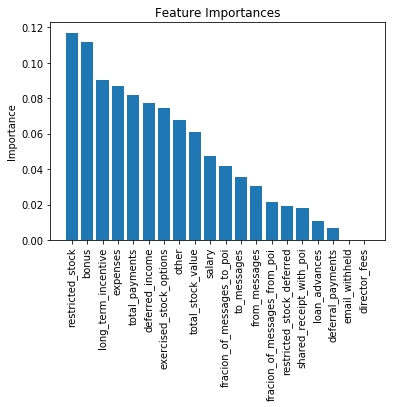

AdaBoost Feature Importances


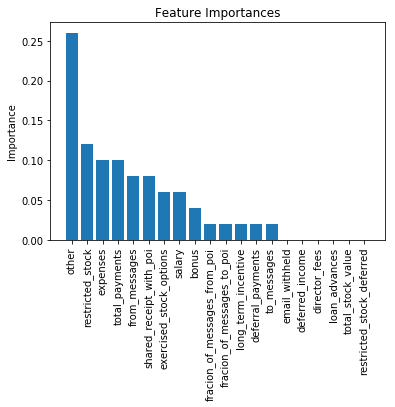

In [26]:
print 'Random Forest Feature Importances'
rf_importances = plot_feature_importances(RandomForestClassifier(), X_new, y)
print 'AdaBoost Feature Importances'
ada_importances = plot_feature_importances(AdaBoostClassifier(), X_new, y)

From the above plots it looks like there is no importance for the feature email_withheld. Apart from that there are few other features which appear to have no importance at all. These features should be dropped.

Intrestingly the top important features looks to be a combination of both email and financial features.

In [27]:
X_new_selected = X_new.drop(ada_importances.keys()[-6:], axis = 1)
X_new_selected.columns

Index([u'salary', u'to_messages', u'deferral_payments', u'total_payments',
       u'exercised_stock_options', u'bonus', u'restricted_stock',
       u'shared_receipt_with_poi', u'expenses', u'from_messages', u'other',
       u'long_term_incentive', u'fracion_of_messages_to_poi',
       u'fracion_of_messages_from_poi'],
      dtype='object')

In [44]:
classifiers_results(X_new_selected, y)

RandomForestClassifier
accuracy 0.869333333333
precision 0.21
recall 0.125
------------------------
GaussianNB Classifier
accuracy 0.822
precision 0.183333333333
recall 0.175
------------------------
AdaBoost Classifier
accuracy 0.865333333333
precision 0.436166666667
recall 0.385


In [29]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

n_features = X_new_selected.shape[1]
grid = {
    'criterion':('gini', 'entropy'),
    'min_samples_leaf':range(1, 50, 5),
    'max_depth': range(1, 10)
}

search = GridSearchCV(RandomForestClassifier(random_state=42),
                      grid, make_scorer(f1_score), cv=StratifiedKFold(y), n_jobs=-1)
search.fit(X_new_selected, y)
print search.best_score_
print search.best_params_

C:\Users\Saisandeep\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.260060362173
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1}


In [32]:
classifier_metrics(search.best_estimator_, X_new_selected, y)

accuracy 0.876666666667
precision 0.3375
recall 0.195


In [33]:
grid = {
    'base_estimator__criterion': ('gini', 'entropy'),
    'base_estimator__min_samples_leaf':range(1, 50, 5),
    'base_estimator__max_depth': range(1, 10),
    'n_estimators': range(1,10)
}

search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), 
                      grid, make_scorer(f1_score), cv=StratifiedKFold(y), n_jobs=-1)
search.fit(X_new_selected, y)
print search.best_score_
print search.best_params_

0.488860435339
{'n_estimators': 1, 'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 11}


In [34]:
classifier_metrics(search.best_estimator_, X_new_selected, y)


accuracy 0.872
precision 0.502
recall 0.5


After the fine tuning it looks like the Adaboost algorithm is performing a lot better. I have decided to use this algorithm.

In [35]:
from sklearn.learning_curve import validation_curve
def plot_validation_curve(clf, X, y, param, param_range):

    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param, param_range=param_range,
        cv=StratifiedKFold(y), scoring=make_scorer(f1_score), n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylabel("Score")
    plt.xlabel(param)
    plt.ylim(0.0, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

C:\Users\Saisandeep\Anaconda2\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


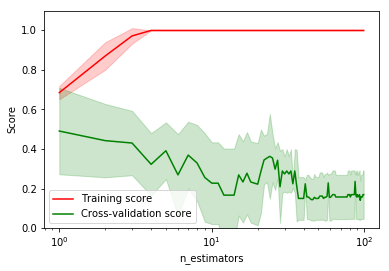

In [36]:
plot_validation_curve(search.best_estimator_, X_new_selected, y, 'n_estimators', range(1,100,1))

GaussianNB(priors=None)
	Accuracy: 0.72340	Precision: 0.23964	Recall: 0.49450	F1: 0.32283	F2: 0.40777
	Total predictions: 15000	True positives:  989	False positives: 3138	False negatives: 1011	True negatives: 9862

